## Happy Eastern, Zuko 🔥

Demo how to sample from a 2 dimensional flow which is trained on samples from an image.

| Image | Training | Samples (learned) |
|:-----:|:--------:|:-----------------:|
| <img src="bunny1.png" width="200" height="200"> | <img src="training.png" width="220" height="220"> | <img src="samplesNSF.png" width="220" height="220"> |


In [2]:
#Installing zuko on colab
#% !pip install git+https://github.com/MArpogaus/zuko.git@bpf_extrapolation
import numpy as np
import torch
import zuko
import matplotlib.pyplot as plt
import sys
print(zuko.__version__)

1.1.0


### Definition of the flow

In [49]:
# Sort so that the one to use is on the bottom


# Using Bernstein Polynomial Flow (BPF)
flow = zuko.flows.BPF(
    features =2,  # Dimension of output (dimension of y)
    context = 0,  # The number of context features. 0 for p(y) and dimension of x in case of p(y|x)
    degree = 64,    # Degree of the Bernstein Polynomial
    transforms=5, # Number of chainings 5 
    hidden_features = [128] * 5  # A fully connected neural network with 3 hidden layers, each 128 features
)
weights = "bunny_bpf_MAF128_5_Trans5_M64.pth"


# Using Neural Spline Flow (NSF)
flow = zuko.flows.NSF(
    features =2,  # Dimension of output (dimension of y)
    context = 0,  # The number of context features. 0 for p(y) and dimension of x in case of p(y|x)
    transforms=5, # Number of chainings 5 
    hidden_features = [128] * 5  # A fully connected neural network with 3 hidden layers, each 128 features
)

weights = "bunny_nsf_MAF128_5_Trans5.pth"


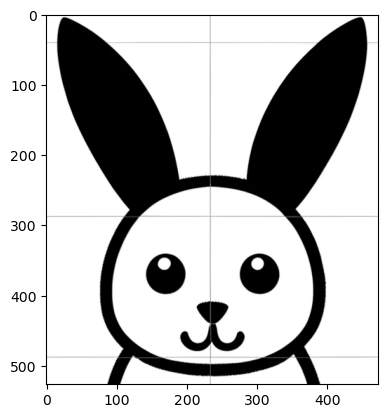

In [40]:
# Parameters
epochs = 1000           # Number of epochs
from PIL import Image
image = Image.open('bunny1.png') #
# Show the image
plt.imshow(image)

#### Generating the training data

In [41]:
# GTP Generated Code 
def sample_points_from_image(image_array, num_samples=1000):
    """
    Sample points from an image array based on intensity values.

    Parameters:
    - image_array: numpy array of the image.
    - num_samples: number of points to sample.

    Returns:
    - x, y: coordinates of the sampled points.
    """
    # Normalize image_array to have values between 0 and 1
    normalized_array = 1 - (image_array / 255.0)  # Invert so darker areas have higher values

    # Cumulative distribution function of the normalized values
    cdf = normalized_array.cumsum()
    cdf = cdf / cdf[-1]

    # Generate random numbers and find corresponding indices in the CDF
    random_numbers = np.random.rand(num_samples)
    indices = np.searchsorted(cdf, random_numbers)

    # Convert flat indices back to 2D coordinates
    y, x = np.unravel_index(indices, image_array.shape)

    return x, y

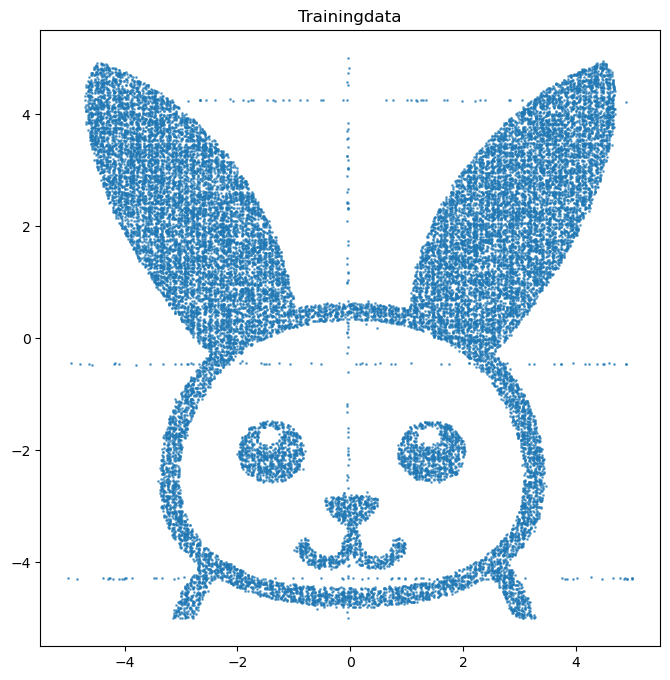

In [50]:
# Convert the image to grayscale for simplicity
gray_image_rabbit = image.convert('L')
gray_array_rabbit = np.array(gray_image_rabbit)

# Sample points from this new image
x_points_rabbit, y_points_rabbit = sample_points_from_image(gray_array_rabbit, 30000)
# Center the data with spread [-5, 5] using min and max values
x_points_rabbit = (x_points_rabbit - x_points_rabbit.min()) / (x_points_rabbit.max() - x_points_rabbit.min()) * 10 - 5
y_points_rabbit = (y_points_rabbit - y_points_rabbit.min()) / (y_points_rabbit.max() - y_points_rabbit.min()) * 10 - 5

# Plot the points for visualization
plt.figure(figsize=(8, 8))
plt.scatter(x_points_rabbit, -y_points_rabbit, s=1, alpha=0.6)
#plt.axis('off')  # Hide axes
plt.title("Trainingdata")
plt.savefig('training.png')
plt.show()
y2d = torch.tensor(np.stack([x_points_rabbit, -y_points_rabbit], axis=1), dtype=torch.float32)

#### Training

In [53]:
from tqdm import trange
import os

# Training file with name weights does not exist
if os.path.exists(weights) == False:
    optimizer = torch.optim.AdamW(flow.parameters())
    loss_history = np.zeros(epochs)
    t = trange(epochs, desc="Epochs")
    for e in t:
        loss = -flow().log_prob(y2d).mean()  # -log p(y)
        loss_history[e] = (loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t.set_description(f"Epochs (loss={loss_history[e]:.4f})")

    plt.title(f"Loss of {flow.__class__.__name__} on the training data")
    plt.plot(loss_history)
    # Saving the flow model
    torch.save(flow.state_dict(), weights)
else:
    flow.load_state_dict(torch.load(weights))

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import os

### Sampling from the distribution

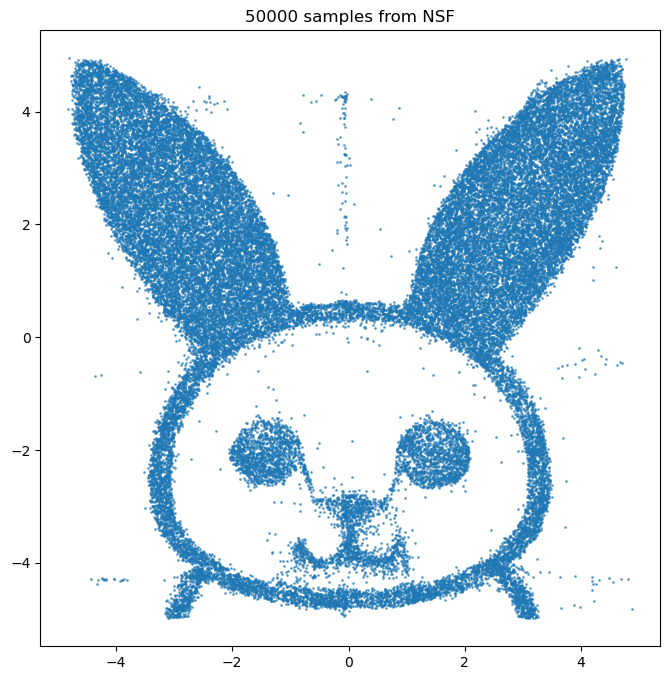

In [55]:
samples = flow().sample((50000,)).detach().numpy()
plt.figure(figsize=(8, 8))
plt.title(f"{samples.shape[0]} samples from {flow.__class__.__name__}")
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.6)
plt.savefig(f"samples{flow.__class__.__name__}.png")

### Creating a mp4 animation

Video saved as samples_animation_easter.mp4


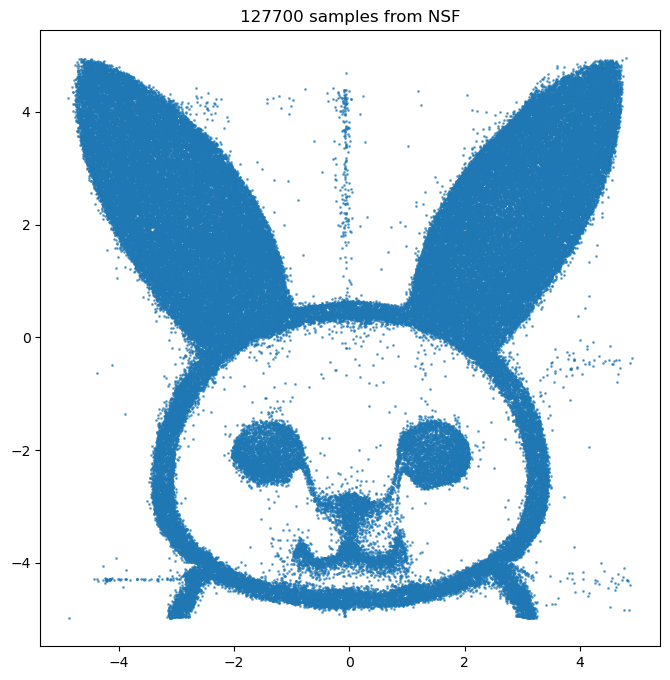

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

def generate_samples(num_samples):
    samples = flow().sample(torch.Size([num_samples])).detach().numpy()
    return samples

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
samples = np.empty((0, 2), dtype=np.float32)

num_frames = 50  # Total number of frames
initial_samples_per_frame = 100  # Initial number of samples to add per frame

def update(frame):
    global samples
    samples_to_add = initial_samples_per_frame * (frame + 1)  # Increasing the number of samples
    new_samples = generate_samples(samples_to_add)
    samples = np.vstack([samples, new_samples])
    ax.clear()
    ax.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.6)
    ax.set_title(f"{len(samples)} samples from {flow.__class__.__name__}")
    # If it's the last frame, add the special message
    if frame == num_frames - 1:
         #ax.text(0.5, 0.66, "Happy Easter from Zuko!", fontsize=35, fontweight='bold', va='center', ha='center', color='red', transform=ax.transAxes)
        ax.text(0.5, 0.66, "Flowe Ostern!", fontsize=35, fontweight='bold', va='center', ha='center', color='red', transform=ax.transAxes)
anim = FuncAnimation(fig, update, frames=range(num_frames), repeat=False)

# Save the animation as an MP4 video
video_path = "samples_animation_easter.mp4"
writer = FFMpegWriter(fps=15, metadata=dict(artist='Zuko'), bitrate=1800)
anim.save(video_path, writer=writer)

print(f"Video saved as {video_path}")
